# Projet Métaheuristique
http://dimacs.rutgers.edu/programs/challenge/vrp/cvrp/<br>
http://vrp.galgos.inf.puc-rio.br/index.php/en/plotted-instances?data=X-n101-k25<br>
http://dimacs.rutgers.edu/files/6916/3848/0327/CVRP_Competition_Rules.pdf<br>
https://www.cirrelt.ca/documentstravail/cirrelt-2011-12.pdf<br>
https://www.jstor.org/stable/pdf/4102067.pdf?refreqid=excelsior%3Ac082c879db7df12627f560be34e84feb&ab_segments=&origin=

In [103]:
Instance = "X-n120-k6"
!wget -c http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances//X/{Instance}.sol -P instances/
!wget -c http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances//X/{Instance}.vrp -P instances/

--2022-03-25 13:37:01--  http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances//X/X-n120-k6.sol
Résolution de vrp.galgos.inf.puc-rio.br (vrp.galgos.inf.puc-rio.br)… 139.82.16.196
Connexion à vrp.galgos.inf.puc-rio.br (vrp.galgos.inf.puc-rio.br)|139.82.16.196|:80… connecté.
requête HTTP transmise, en attente de la réponse… 416 Requested Range Not Satisfiable

    Le fichier a déjà été complètement récupéré ; rien à faire.

--2022-03-25 13:37:02--  http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances//X/X-n120-k6.vrp
Résolution de vrp.galgos.inf.puc-rio.br (vrp.galgos.inf.puc-rio.br)… 139.82.16.196
Connexion à vrp.galgos.inf.puc-rio.br (vrp.galgos.inf.puc-rio.br)|139.82.16.196|:80… connecté.
requête HTTP transmise, en attente de la réponse… 416 Requested Range Not Satisfiable

    Le fichier a déjà été complètement récupéré ; rien à faire.



In [104]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
problem = open("instances/"+Instance+".vrp", "r")
print(problem.read(398))

NAME : 	X-n120-k6	
COMMENT : 	"Generated by Uchoa, Pecin, Pessoa, Poggi, Subramanian, and Vidal (2013)"	
TYPE : 	CVRP	
DIMENSION : 	120	
EDGE_WEIGHT_TYPE : 	EUC_2D	
CAPACITY : 	21	
NODE_COORD_SECTION		
1	0	0
2	927	318
3	319	475
4	471	281
5	894	615
6	712	832
7	677	210
8	336	967
9	490	360
10	367	685
11	153	169
12	799	63
13	247	455
14	492	585
15	131	701
16	309	721
17	210	256
18	511	753
19	447	796
2


In [105]:
# The input files follow the "Augerat" format.
import math
import sys
def read_input_cvrp(filename):
    file_it = iter(read_elem(filename))
    nb_trucks = get_nb_trucks(filename)
    nb_nodes = 0
    while (1):
        token = next(file_it)
        if token == "DIMENSION":
            next(file_it)  # Removes the ":"
            nb_nodes = int(next(file_it))
            nb_customers = nb_nodes - 1
        elif token == "CAPACITY":
            next(file_it)  # Removes the ":"
            truck_capacity = int(next(file_it))
        elif token == "EDGE_WEIGHT_TYPE":
            next(file_it)  # Removes the ":"
            token = next(file_it)
            if token != "EUC_2D":
                print("Edge Weight Type " + token + " is not supported (only EUD_2D)")
                sys.exit(1)
        elif token == "NODE_COORD_SECTION":
            break

    customers_x = [None] * nb_customers
    customers_y = [None] * nb_customers
    depot_x = 0
    depot_y = 0
    for n in range(nb_nodes):
        node_id = int(next(file_it))
        if node_id != n + 1:
            print("Unexpected index")
            sys.exit(1)
        if node_id == 1:
            depot_x = int(next(file_it))
            depot_y = int(next(file_it))
        else:
            # -2 because orginal customer indices are in 2..nbNodes
            customers_x[node_id - 2] = int(next(file_it))
            customers_y[node_id - 2] = int(next(file_it))

    # Compute distance matrix
    distance_matrix = compute_distance_matrix(customers_x, customers_y)
    distance_warehouses = compute_distance_warehouses(depot_x, depot_y, customers_x, customers_y)

    token = next(file_it)
    if token != "DEMAND_SECTION":
        print("Expected token DEMAND_SECTION")
        sys.exit(1)

    demands = [None] * nb_customers
    for n in range(nb_nodes):
        node_id = int(next(file_it))
        if node_id != n + 1:
            print("Unexpected index")
            sys.exit(1)
        if node_id == 1:
            if int(next(file_it)) != 0:
                print("Demand for depot should be 0")
                sys.exit(1)
        else:
            # -2 because orginal customer indices are in 2..nbNodes
            demands[node_id - 2] = int(next(file_it))

    token = next(file_it)
    if token != "DEPOT_SECTION":
        print("Expected token DEPOT_SECTION")
        sys.exit(1)

    warehouse_id = int(next(file_it))
    if warehouse_id != 1:
        print("Warehouse id is supposed to be 1")
        sys.exit(1)

    end_of_depot_section = int(next(file_it))
    if end_of_depot_section != -1:
        print("Expecting only one warehouse, more than one found")
        sys.exit(1)
    return (nb_customers, customers_x, customers_y, nb_trucks, truck_capacity, distance_matrix, depot_x, depot_y, distance_warehouses, demands)

def read_elem(filename):
    with open(filename) as f:
        return [str(elem) for elem in f.read().split()]

# Computes the distance matrix
def compute_distance_matrix(customers_x, customers_y):
    nb_customers = len(customers_x)
    distance_matrix = [[None for i in range(nb_customers)] for j in range(nb_customers)]
    for i in range(nb_customers):
        distance_matrix[i][i] = 0
        for j in range(nb_customers):
            dist = compute_dist(customers_x[i], customers_x[j], customers_y[i], customers_y[j])
            distance_matrix[i][j] = dist
            distance_matrix[j][i] = dist
    return distance_matrix


# Computes the distances to warehouse
def compute_distance_warehouses(depot_x, depot_y, customers_x, customers_y):
    nb_customers = len(customers_x)
    distance_warehouses = [None] * nb_customers
    for i in range(nb_customers):
        dist = compute_dist(depot_x, customers_x[i], depot_y, customers_y[i])
        distance_warehouses[i] = dist
    return distance_warehouses


def compute_dist(xi, xj, yi, yj):
    exact_dist = math.sqrt(math.pow(xi - xj, 2) + math.pow(yi - yj, 2))
    return int(math.floor(exact_dist + 0.5))


def get_nb_trucks(filename):
    begin = filename.rfind("-k")
    if begin != -1:
        begin += 2
        end = filename.find(".", begin)
        return int(filename[begin:end])
    print("Error: nb_trucks could not be read from the file name. Enter it from the command line")
    sys.exit(1)

In [106]:
nb_customers, customers_x, customers_y, nb_trucks, truck_capacity, distance_matrix, depot_x, depot_y, distance_warehouses, demands = read_input_cvrp("instances/"+Instance+".vrp")
print("-- CUSTOMERS --")
print("There are",nb_customers,"customers")
print("- X position of the customers is size",np.array(customers_x).shape)
print("- Y position of the customers is size",np.array(customers_y).shape)
print("The demand of each client are is size",len(demands))
print("The distance matrix is size (euclidian distances between customer_x and customers_y)",np.array(distance_matrix).shape)
print("-- TRUCKS --")
print("There are at least",nb_trucks,"trucks")
print("The truck capacity is",truck_capacity)
print("-- WAREHOUSES --")
print("- X position of the warehouse",depot_x)
print("- Y position of the warehouse",depot_y)
print("The distance of each client to the warehouses are (euclidian distance between customer_x and warehouse) is size",len(distance_warehouses))

-- CUSTOMERS --
There are 119 customers
- X position of the customers is size (119,)
- Y position of the customers is size (119,)
The demand of each client are is size 119
The distance matrix is size (euclidian distances between customer_x and customers_y) (119, 119)
-- TRUCKS --
There are at least 6 trucks
The truck capacity is 21
-- WAREHOUSES --
- X position of the warehouse 0
- Y position of the warehouse 0
The distance of each client to the warehouses are (euclidian distance between customer_x and warehouse) is size 119


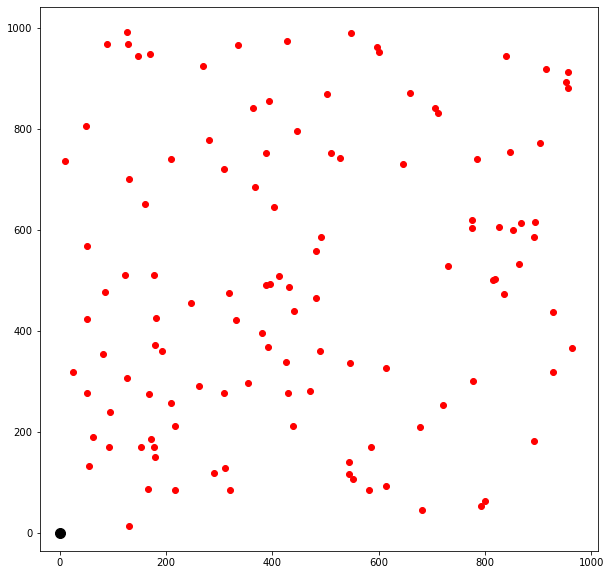

In [107]:
plt.figure(figsize=(10,10))
plt.scatter(customers_x,customers_y,c="r")
plt.scatter(depot_x,depot_y,c="black",s=100)
plt.show()

## Route First

In [108]:
nb_customers, customers_x, customers_y, nb_trucks, truck_capacity, distance_matrix, depot_x, depot_y, distance_warehouses, demands = read_input_cvrp(Instance+".vrp")
print("-- CUSTOMERS --")
print("There are",nb_customers,"customers")
print("- X position of the customers is size",np.array(customers_x).shape)
print("- Y position of the customers is size",np.array(customers_y).shape)
print("The demand of each client are is size",len(demands))
print("The distance matrix is size (euclidian distances between customer_x and customers_y)",np.array(distance_matrix).shape)
print("-- TRUCKS --")
print("There are at least",nb_trucks,"trucks")
print("The truck capacity is",truck_capacity)
print("-- WAREHOUSES --")
print("- X position of the warehouse",depot_x)
print("- Y position of the warehouse",depot_y)
print("The distance of each client to the warehouses are (euclidian distance between customer_x and warehouse) is size",len(distance_warehouses))

-- CUSTOMERS --
There are 119 customers
- X position of the customers is size (119,)
- Y position of the customers is size (119,)
The demand of each client are is size 119
The distance matrix is size (euclidian distances between customer_x and customers_y) (119, 119)
-- TRUCKS --
There are at least 6 trucks
The truck capacity is 21
-- WAREHOUSES --
- X position of the warehouse 0
- Y position of the warehouse 0
The distance of each client to the warehouses are (euclidian distance between customer_x and warehouse) is size 119


# Heuristique
 - On crée une liste de clients à dispatcher.
 - On ajoute le premier élément de cette liste dans une route vide.
 - Ensuite on prend à chaque fois le client le plus proche du dernier client ajouté dans la route et tant que la somme des demandes de la route ne dépasse pas la capacité d'un camion, on ajoute le plus proche voisin.
 - Une fois que l'on ne peut plus ajouter aucun voisin à la route, on ajoute la route à la liste des routes.

In [109]:
def get_route_cost(route):
    total_cost = 0
    # Trajets jusqu'au dépôt
    x_values = [depot_x, customers_x[route[0]]]
    y_values = [depot_y, customers_y[route[0]]]
    total_cost += compute_dist(x_values[0],x_values[1],y_values[0],y_values[1])
    x_values = [depot_x, customers_x[route[-1]]]
    y_values = [depot_y, customers_y[route[-1]]]
    total_cost += compute_dist(x_values[0],x_values[1],y_values[0],y_values[1])
    # Trajet entre clients
    for nb_customer in range(len(route)-1):
        x_values = [customers_x[route[nb_customer]], customers_x[route[nb_customer+1]]]
        y_values = [customers_y[route[nb_customer]], customers_y[route[nb_customer+1]]]
        total_cost += compute_dist(x_values[0],x_values[1],y_values[0],y_values[1])
    return total_cost

def get_route_capacity(route):
    total_capacity= 0
    # Trajet entre clients
    for customer in route:
        total_capacity += demands[customer]
    return total_capacity

def get_closest_from_warehouse(customers_list):
    closest_customer = customers_list[0]
    for customer in customers_list:
        if distance_warehouses[customer]<distance_warehouses[closest_customer]:
            closest_customer = customer
        if distance_warehouses[customer]<distance_warehouses[closest_customer]:
            closest_customer = max(customer,closest_customer)
    return closest_customer

def get_closest_customer(current_customer,customers_list):
    closest_customer = customers_list[0] # Initialisation
    for new_customer in customers_list:
        smallest_distance = compute_dist(customers_x[current_customer],customers_x[closest_customer],customers_y[current_customer],customers_y[closest_customer]) 
        customer_distance = compute_dist(customers_x[current_customer],customers_x[new_customer],customers_y[current_customer],customers_y[new_customer]) 
        if customer_distance < smallest_distance:
            closest_customer = new_customer
        if customer_distance == smallest_distance:
            closest_customer = max(new_customer,closest_customer)
    return closest_customer

import random
def create_routes(custom_truck_capacity, initialization = 1):
    customers_list = list(np.arange(0,nb_customers,1)) # Initialisation
    random.shuffle(customers_list) # Aucun impact sur les performances
    routes = []
    while (len(customers_list)!=0):
        # print("Liste à dispatcher :",customers_list)
        route=[]
        if initialization==1:
            closest_customer = get_closest_from_warehouse(customers_list) # Initialisation
        if initialization==2:
            closest_customer = random.choice(customers_list) # Initialisation
        route_capacity = 0
        while (route_capacity + demands[closest_customer] <= custom_truck_capacity) and (len(customers_list)!=0):
            route.append(closest_customer)
            route_capacity = sum([demands[customer] for customer in route])
            customers_list.remove(closest_customer)
            if len(customers_list) > 0:
                closest_customer = get_closest_customer(route[-1],customers_list)
        routes.append(route)
        # print("Route:",route)
        # print("Demande:",route_capacity)
        # print("-------")
    return routes

def display_routes(routes):
    df = pd.DataFrame(columns=["customers_x","customers_y","demands","route"])
    route_number = 0
    iterator = 0
    for route in routes:
        for customer in route:
            new_line = np.array([customers_x[customer],customers_y[customer],demands[customer],route_number])
            df.loc[iterator]=new_line
            iterator += 1
        route_number += 1
        
    cmap = plt.get_cmap('jet', len(routes))
    cmap.set_under('gray')
    fig = plt.figure(figsize=(15,15))
    renderer = fig.canvas.get_renderer()
    for customer in range(nb_customers):
        plt.annotate(str(customer),[customers_x[customer],customers_y[customer]], )
        
    # Clients
    plt.scatter(df["customers_x"],df["customers_y"],c=df["route"],cmap=cmap,s=300)
    plt.colorbar()

    # Dépot
    plt.scatter(depot_x,depot_y,c="black",s=1000,marker='s')

    # Routes
    for route in routes:
        
        # Trajets jusqu'au dépôt
        x_values = [depot_x, customers_x[route[0]]]
        y_values = [depot_y, customers_y[route[0]]]
        plt.plot(x_values, y_values, marker="None", linestyle="--", c="lightgray")
        x_values = [depot_x, customers_x[route[-1]]]
        y_values = [depot_y, customers_y[route[-1]]]
        plt.plot(x_values, y_values, marker="None", linestyle="--", c="lightgray")
        
        
        # Trajet entre clients
        for nb_customer in range(len(route)-1):
            x_values = [customers_x[route[nb_customer]], customers_x[route[nb_customer+1]]]
            y_values = [customers_y[route[nb_customer]], customers_y[route[nb_customer+1]]]
            plt.plot(x_values, y_values, marker="None", linestyle="-", c="black")
    plt.axis('scaled')

    plt.show()
    return df

# Initialisation

Cost | Capacity for route 0 : 1705 | 21
Cost | Capacity for route 1 : 2212 | 21
Cost | Capacity for route 2 : 2985 | 21
Cost | Capacity for route 3 : 2811 | 21
Cost | Capacity for route 4 : 3430 | 21
Cost | Capacity for route 5 : 2705 | 14
Total cost =  15848
[[19, 115, 106, 60, 118, 93, 9, 87, 51, 49, 37, 30, 72, 24, 28, 79, 15, 83, 92, 54, 69], [95, 70, 53, 111, 44, 2, 77, 38, 41, 48, 1, 42, 75, 112, 63, 108, 81, 97, 12, 98, 8], [31, 90, 20, 11, 78, 117, 29, 66, 32, 22, 13, 57, 82, 14, 43, 17, 16, 102, 40, 4, 25], [86, 71, 61, 39, 110, 101, 33, 26, 10, 55, 0, 23, 36, 56, 99, 76, 58, 21, 3, 94, 59], [7, 113, 89, 91, 5, 34, 52, 80, 68, 67, 84, 88, 50, 62, 103, 104, 100, 46, 116, 107, 65], [35, 114, 47, 64, 85, 73, 109, 105, 6, 96, 45, 74, 18, 27]]


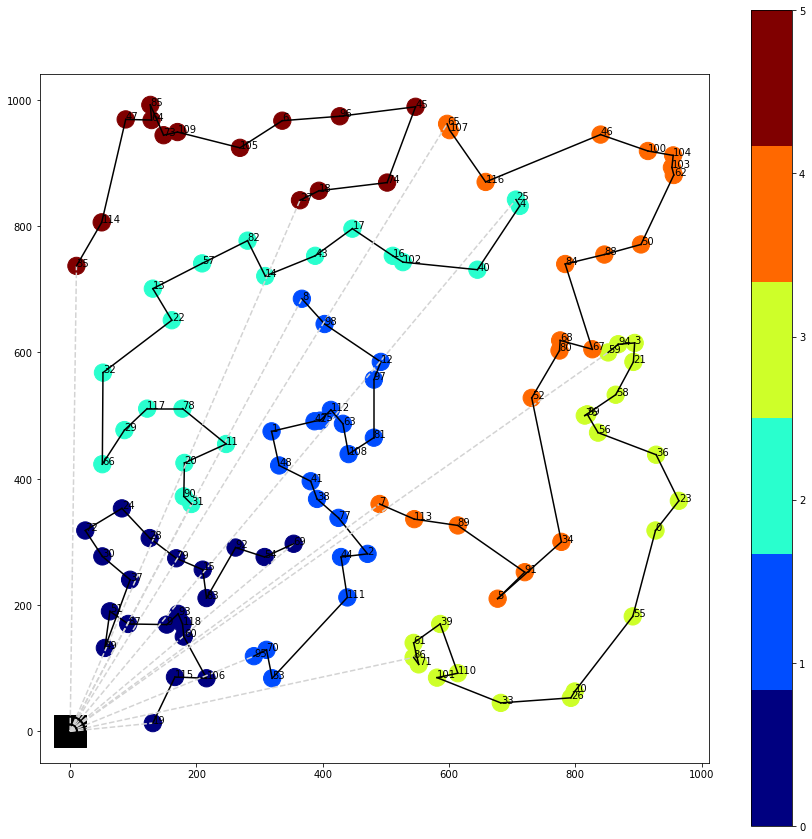

In [110]:
custom_truck_capacity = truck_capacity
routes = create_routes(custom_truck_capacity)

# Calcul du coût des routes
total_cost = 0 
for nb_route,route in enumerate(routes):
    print("Cost | Capacity for route {} : {} | {}".format(nb_route,get_route_cost(route),get_route_capacity(route)))
    total_cost+=get_route_cost(route)
print("Total cost = ",total_cost)
print(routes)
df = display_routes(routes)

# Changement d'initialisation
## Randomized-Initialisation

In [111]:
from tqdm import tqdm

trials_costs = []
trials_routes = []

for _ in tqdm(range(10000)):
    custom_truck_capacity = truck_capacity
    routes = create_routes(custom_truck_capacity,initialization=2) # Initialisation aléatoire

    # Calcul du coût des routes
    total_cost = 0 
    for nb_route,route in enumerate(routes):
        total_cost+=get_route_cost(route)
    # print("Total cost = ",total_cost)
    # print(routes)
    trials_routes.append(routes)
    trials_costs.append(total_cost)

100%|██████████| 10000/10000 [01:04<00:00, 156.06it/s]


The best cost we found is : 15110
The best routes for this cost are : [[52, 80, 68, 67, 59, 94, 3, 21, 58, 99, 76, 56, 36, 23, 0, 55, 10, 26, 33, 110, 101], [98, 8, 14, 82, 57, 13, 22, 32, 117, 29, 66, 24, 28, 79, 15, 83, 93, 118, 60, 9, 87], [49, 51, 37, 30, 72, 90, 31, 20, 11, 1, 48, 41, 38, 77, 44, 2, 111, 69, 54, 92, 70], [43, 17, 16, 102, 40, 4, 25, 116, 107, 65, 45, 96, 6, 105, 109, 73, 64, 85, 47, 114, 35], [75, 42, 112, 63, 108, 81, 97, 12, 7, 113, 89, 91, 5, 39, 61, 86, 71, 53, 95, 106, 115], [34, 84, 88, 50, 62, 103, 104, 100, 46, 74, 18, 27, 78, 19]]
Cost | Capacity for route 0 : 2669 | 21
Cost | Capacity for route 1 : 2173 | 21
Cost | Capacity for route 2 : 1853 | 21
Cost | Capacity for route 3 : 2993 | 21
Cost | Capacity for route 4 : 2251 | 21
Cost | Capacity for route 5 : 3171 | 14
Total cost =  15110


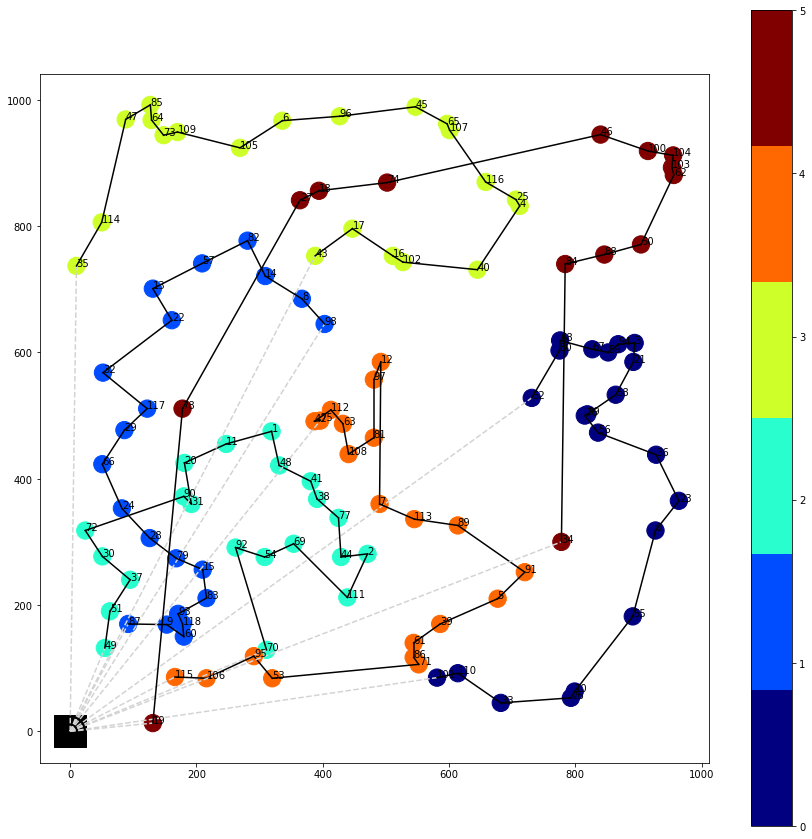

In [112]:
print("The best cost we found is :",min(trials_costs))
best_routes = trials_routes[np.argmin(trials_costs)]
print("The best routes for this cost are :",best_routes)
total_cost = 0
new_routes = []
for nb_route,route in enumerate(best_routes):
    print("Cost | Capacity for route {} : {} | {}".format(nb_route,get_route_cost(route),get_route_capacity(route)))
    total_cost+=get_route_cost(route)
print("Total cost = ",total_cost)
df = display_routes(best_routes)

# Optimisation

In [113]:
def reorder_route_v1(route):
    if len(route)>2:
        customers_left = route.copy()
        # print("Route de base :",customers_left)
        
        best_route = [get_closest_from_warehouse(customers_left)]
        # print("Route begins by customer :",best_route[0])
        customers_left.remove(best_route[0])
        
        route_end = get_closest_from_warehouse(customers_left)
        # print("Route ends by customer :",route_end)
        customers_left.remove(route_end)
                
        while len(customers_left)>0:
            closest_customer = customers_left[0]
            closest_distance = compute_dist(customers_x[customers_left[0]],customers_x[best_route[-1]],customers_y[customers_left[0]],customers_y[best_route[-1]])
            # print("----")
            # print("Reste à dispatcher:",customers_left)
            for customer in customers_left:
                new_dist = compute_dist(customers_x[customer],customers_x[best_route[-1]],customers_y[customer],customers_y[best_route[-1]])
                if new_dist < closest_distance :
                    closest_customer = customer
                    closest_distance = new_dist
            # print("Client suivant :",closest_customer)
            customers_left.remove(closest_customer)
            # print("Client restant :",customers_left)
            best_route.append(closest_customer)
            # print("Middle Route :",middle_route)
            
        best_route.append(route_end)
        return(best_route)
    else :
        return(route)

def reorder_route_v2(route):
    if len(route)>1:
        customers_left = route.copy()
        # print("Route de base :",customers_left)
        
        best_route = [get_closest_from_warehouse(customers_left)]
        # print("Route begins by customer :",best_route[0])
        customers_left.remove(best_route[0])
                
        while len(customers_left)>0:
            closest_customer = customers_left[0]
            closest_distance = compute_dist(customers_x[customers_left[0]],customers_x[best_route[-1]],customers_y[customers_left[0]],customers_y[best_route[-1]])
            # print("----")
            # print("Reste à dispatcher:",customers_left)
            for customer in customers_left:
                new_dist = compute_dist(customers_x[customer],customers_x[best_route[-1]],customers_y[customer],customers_y[best_route[-1]])
                if new_dist < closest_distance :
                    closest_customer = customer
                    closest_distance = new_dist
            # print("Client suivant :",closest_customer)
            customers_left.remove(closest_customer)
            # print("Client restant :",customers_left)
            best_route.append(closest_customer)
            # print("Middle Route :",middle_route)

        return(best_route)
    else :
        return(route)

## V1 : 

### On définit dès le départ le point de départ et d'arrivée de la route (les 2 points de la route les plus proches du dépot)

Cost | Capacity for route 0 : 2849 | 21
Cost | Capacity for route 1 : 2185 | 21
Cost | Capacity for route 2 : 1968 | 21
Cost | Capacity for route 3 : 3311 | 21
Cost | Capacity for route 4 : 2312 | 21
Cost | Capacity for route 5 : 3086 | 14
Total cost =  15711
[[101, 33, 26, 10, 55, 0, 23, 36, 56, 99, 76, 58, 21, 3, 94, 59, 67, 80, 68, 52, 110], [87, 93, 118, 60, 83, 15, 79, 28, 24, 66, 29, 117, 32, 22, 13, 57, 82, 14, 8, 98, 9], [49, 37, 30, 72, 90, 31, 20, 11, 1, 48, 41, 38, 77, 44, 2, 111, 69, 54, 92, 70, 51], [35, 47, 64, 85, 73, 109, 105, 6, 96, 45, 65, 107, 116, 25, 4, 40, 102, 16, 17, 43, 114], [115, 95, 53, 86, 71, 61, 39, 5, 91, 89, 113, 7, 108, 81, 63, 112, 75, 42, 97, 12, 106], [19, 34, 84, 88, 50, 62, 103, 104, 100, 46, 74, 18, 27, 78]]


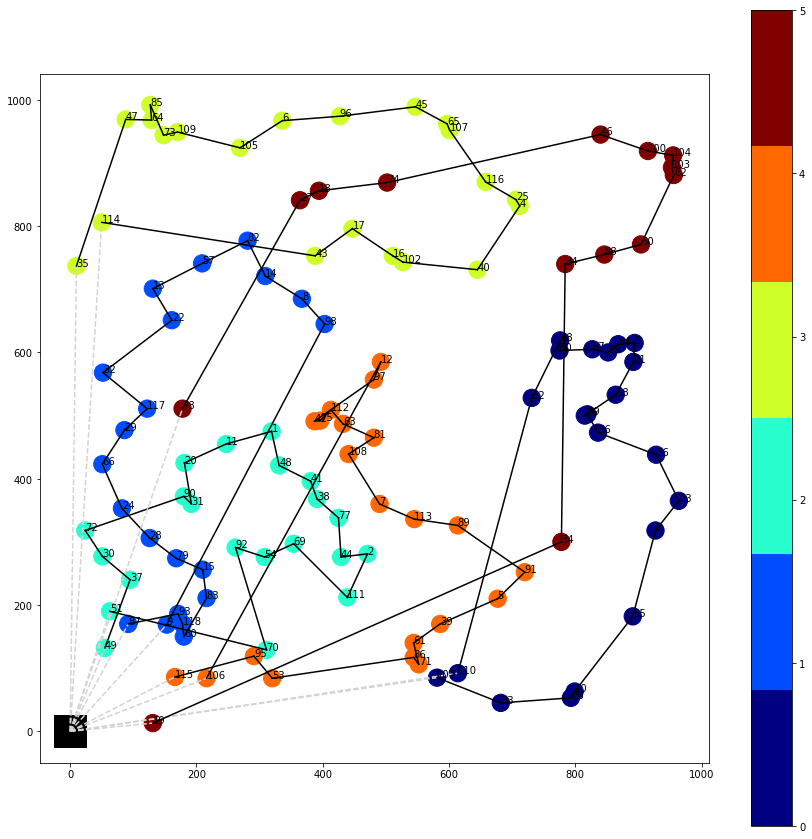

In [114]:
total_cost = 0
new_routes = []
for nb_route,route in enumerate(best_routes):
    best = reorder_route_v1(route)
    new_routes.append(best)
    print("Cost | Capacity for route {} : {} | {}".format(nb_route,get_route_cost(best),get_route_capacity(best)))
    total_cost+=get_route_cost(best)
print("Total cost = ",total_cost)
print(new_routes)
df = display_routes(new_routes)

## V2 : 

### On définit dès le départ seulement le point de départ de la route : le plus proche du dépot

Cost | Capacity for route 0 : 2687 | 21
Cost | Capacity for route 1 : 2185 | 21
Cost | Capacity for route 2 : 1853 | 21
Cost | Capacity for route 3 : 3010 | 21
Cost | Capacity for route 4 : 2276 | 21
Cost | Capacity for route 5 : 3343 | 14
Total cost =  15354
[[101, 110, 33, 26, 10, 55, 0, 23, 36, 56, 99, 76, 58, 21, 3, 94, 59, 67, 80, 68, 52], [87, 9, 93, 118, 60, 83, 15, 79, 28, 24, 66, 29, 117, 32, 22, 13, 57, 82, 14, 8, 98], [49, 51, 37, 30, 72, 90, 31, 20, 11, 1, 48, 41, 38, 77, 44, 2, 111, 69, 54, 92, 70], [35, 114, 47, 64, 85, 73, 109, 105, 6, 96, 45, 65, 107, 116, 25, 4, 40, 102, 16, 17, 43], [115, 106, 95, 53, 86, 71, 61, 39, 5, 91, 89, 113, 7, 108, 81, 63, 112, 75, 42, 97, 12], [19, 78, 27, 18, 74, 84, 88, 50, 62, 103, 104, 100, 46, 34]]


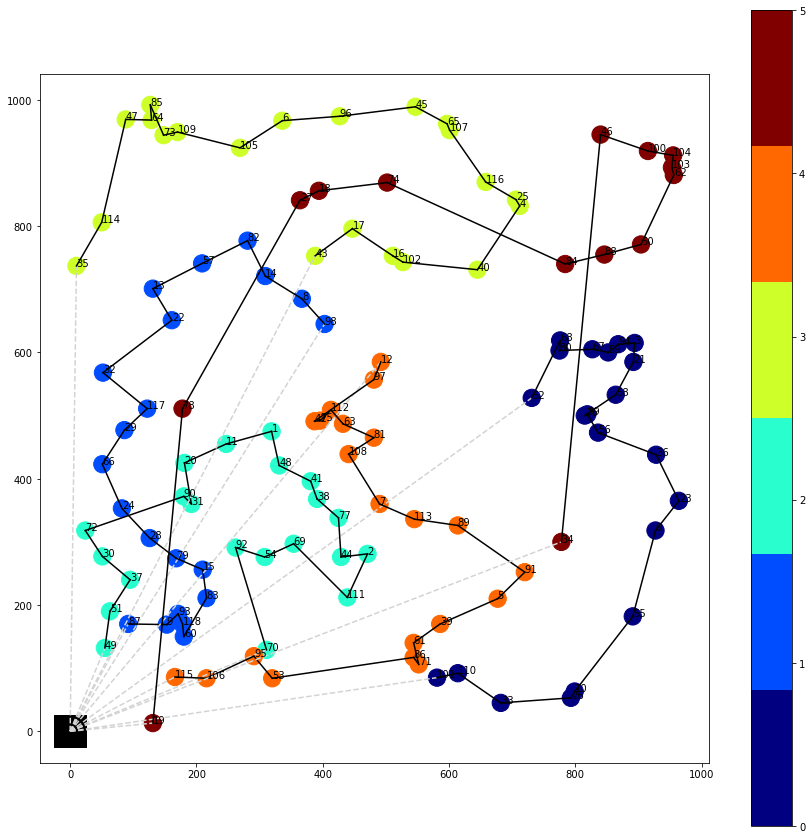

In [115]:
total_cost = 0
new_routes_v2 = []
for nb_route,route in enumerate(best_routes):
    best = reorder_route_v2(route)
    new_routes_v2.append(best)
    print("Cost | Capacity for route {} : {} | {}".format(nb_route,get_route_cost(best),get_route_capacity(best)))
    total_cost+=get_route_cost(best)
print("Total cost = ",total_cost)
print(new_routes_v2)
df = display_routes(new_routes_v2)